<a href="https://colab.research.google.com/github/Hcxgraphics/flightLogAnalysis/blob/main/flightLoganalysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:

import pandas as pd
import numpy as np
from geopy.distance import geodesic
import matplotlib.pyplot as plt
from google.colab import files

In [ ]:

uploaded = files.upload()

Saving DJIFlightRecord_2025-02-23_[11-35-45].csv to DJIFlightRecord_2025-02-23_[11-35-45].csv


In [ ]:

filename = next(iter(uploaded))
with open(filename, 'r') as f:
    lines = f.readlines()

header_index = None
for i, line in enumerate(lines):
    if 'OSD.latitude' in line:
        header_index = i
        break


In [ ]:
df = pd.read_csv(filename, skiprows=header_index)
cols_needed = [
    'OSD.flyTime [s]', 'OSD.latitude', 'OSD.longitude',
    'OSD.altitude [ft]', 'OSD.hSpeed [MPH]', 'OSD.zSpeed [MPH]',
    'OSD.xSpeed [MPH]', 'OSD.ySpeed [MPH]', 'WEATHER.windSpeed [MPH]', 'WEATHER.maxWindSpeed [MPH]'
]
df = df[cols_needed].copy()
df = df.apply(pd.to_numeric, errors='coerce')
df = df.dropna(subset=['OSD.latitude', 'OSD.longitude', 'OSD.flyTime [s]'])
df = df.sort_values(by='OSD.flyTime [s]').reset_index(drop=True)


df['hSpeed_mps'] = df['OSD.hSpeed [MPH]'] * 0.44704
df['zSpeed_mps'] = df['OSD.zSpeed [MPH]'] * 0.44704
df['xSpeed_mps'] = df['OSD.xSpeed [MPH]'] * 0.44704
df['ySpeed_mps'] = df['OSD.ySpeed [MPH]'] * 0.44704
df['windSpeed_mps'] = df['WEATHER.windSpeed [MPH]'] * 0.44704
df['maxWindSpeed_mps'] = df['WEATHER.maxWindSpeed [MPH]'] * 0.44704

/tmp/ipython-input-28-3054159701.py:1: DtypeWarning: Columns (26,192) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(filename, skiprows=header_index)


In [ ]:

distances = [0]
speeds = [0]
for i in range(1, len(df)):
    coord1 = (df.loc[i-1, 'OSD.latitude'], df.loc[i-1, 'OSD.longitude'])
    coord2 = (df.loc[i, 'OSD.latitude'], df.loc[i, 'OSD.longitude'])
    time_diff = df.loc[i, 'OSD.flyTime [s]'] - df.loc[i-1, 'OSD.flyTime [s]']
    dist = geodesic(coord1, coord2).meters
    speed = dist / time_diff if time_diff > 0 else 0
    distances.append(dist)
    speeds.append(speed)

df['distance_m'] = distances
df['gps_speed_mps'] = speeds


In [ ]:

print("\n--- Flight Summary ---")
print(f"Total Flight Time: {df['OSD.flyTime [s]'].max():.2f} seconds")
print(f"Total Distance Travelled: {df['distance_m'].sum():.2f} meters")
print(f"Average GPS Speed: {df['gps_speed_mps'].mean():.2f} m/s")
print(f"Max GPS Speed: {df['gps_speed_mps'].max():.2f} m/s")



--- Flight Summary ---
Total Flight Time: 892.90 seconds
Total Distance Travelled: 3565.95 meters
Average GPS Speed: 4.02 m/s
Max GPS Speed: 21.99 m/s


In [ ]:
wind_data = df[['windSpeed_mps', 'maxWindSpeed_mps']].dropna()
if not wind_data.empty:
    print("\n--- Wind Summary ---")
    print(f"Average Wind Speed: {wind_data['windSpeed_mps'].mean():.2f} m/s")
    print(f"Max Wind Speed: {wind_data['maxWindSpeed_mps'].max():.2f} m/s")
else:
    print("\n⚠️ No wind data available in this flight log.")


--- Wind Summary ---
Average Wind Speed: 6.55 m/s
Max Wind Speed: 12.10 m/s


In [ ]:

hover_df = df[df['OSD.hSpeed [MPH]'] < 0.1].copy()
hover_drift = 0
hover_durations = []

for i in range(1, len(hover_df)):
    coord1 = (hover_df.iloc[i-1]['OSD.latitude'], hover_df.iloc[i-1]['OSD.longitude'])
    coord2 = (hover_df.iloc[i]['OSD.latitude'], hover_df.iloc[i]['OSD.longitude'])
    dist = geodesic(coord1, coord2).meters
    hover_drift += dist

    dt = hover_df.iloc[i]['OSD.flyTime [s]'] - hover_df.iloc[i-1]['OSD.flyTime [s]']
    if dt > 0:
        hover_durations.append(dt)


total_hover_time = sum(hover_durations)
avg_hover_displacement = hover_drift / total_hover_time if total_hover_time > 0 else 0


avg_hover_wind = hover_df['windSpeed_mps'].mean()

print(f"\n--- Hover Drift Estimate ---")
print(f"Total Displacement While Hovering: {hover_drift:.2f} meters")
print(f"Total Hover Duration: {total_hover_time:.2f} seconds")
print(f"Average Displacement when hovering (due to wind): {avg_hover_displacement:.2f} m/s")
print(f"Average Wind Speed During Hover: {avg_hover_wind:.2f} m/s")



--- Hover Drift Estimate ---
Total Displacement While Hovering: 3098.61 meters
Total Hover Duration: 892.90 seconds
Average Displacement when hovering (due to wind): 3.47 m/s
Average Wind Speed During Hover: 6.01 m/s


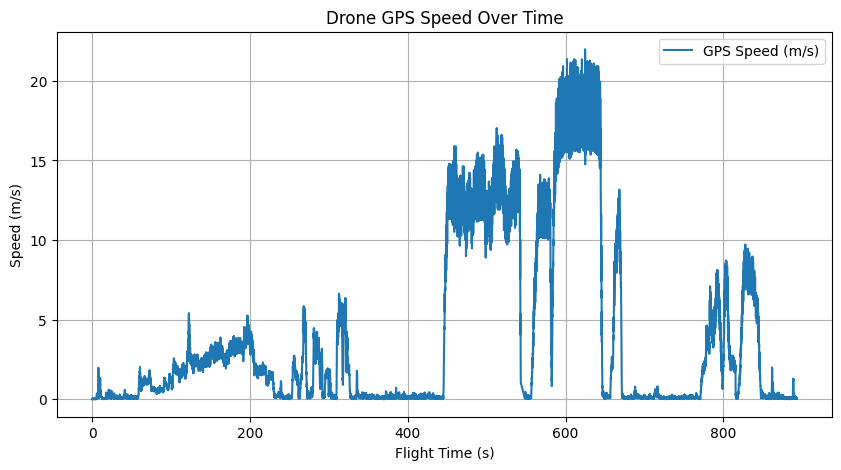

In [ ]:

plt.figure(figsize=(10, 5))
plt.plot(df['OSD.flyTime [s]'], df['gps_speed_mps'], label='GPS Speed (m/s)')
plt.xlabel('Flight Time (s)')
plt.ylabel('Speed (m/s)')
plt.title('Drone GPS Speed Over Time')
plt.grid(True)
plt.legend()
plt.show()


/tmp/ipython-input-23-335800492.py:44: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  wind_speed_limited = hover_df.loc[time_limit_mask, 'WEATHER.windSpeed [MPH]'].fillna(method='ffill')
/tmp/ipython-input-23-335800492.py:45: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  drone_speed_limited = hover_df.loc[time_limit_mask, 'OSD.hSpeed [MPH]'].fillna(method='ffill')


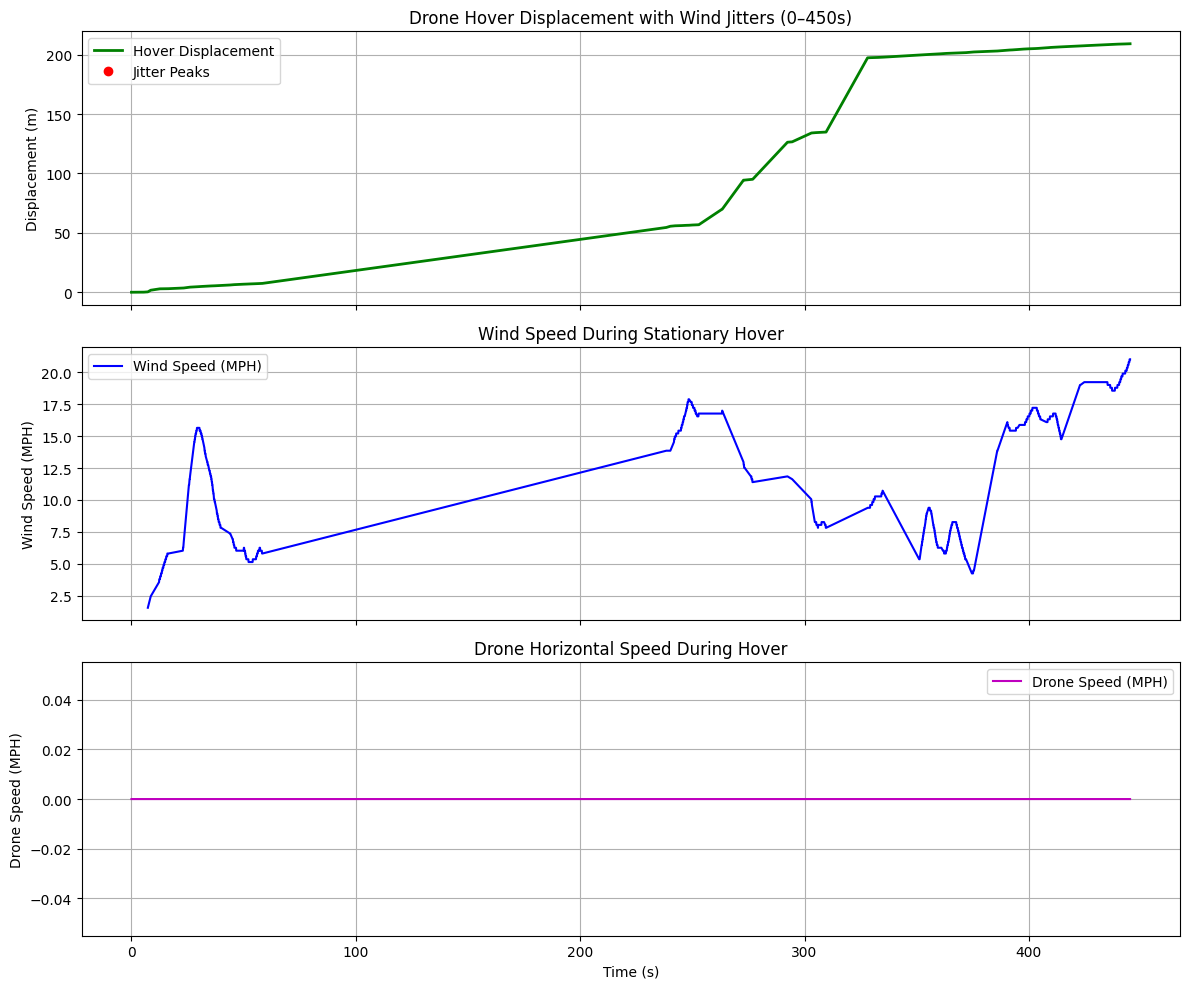

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from geopy.distance import geodesic
from scipy.signal import find_peaks


hover_df = df[
    (df['OSD.hSpeed [MPH]'] < 0.1) &
    (df['OSD.zSpeed [MPH]'].abs() < 0.1)
].copy().reset_index(drop=True)

if len(hover_df) < 2:
    print("⚠️ Not enough valid hover data to compute displacement.")
else:

    lat_diff = hover_df['OSD.latitude'].diff().abs()
    lon_diff = hover_df['OSD.longitude'].diff().abs()
    tiny_motion = (lat_diff < 0.00005) & (lon_diff < 0.00005)
    tiny_motion.iloc[0] = True
    hover_df = hover_df[tiny_motion].reset_index(drop=True)

    if len(hover_df) < 2:
        print("⚠️ Hover points too sparse after filtering.")
    else:

        hover_displacements = [0]
        hover_times = [hover_df.loc[0, 'OSD.flyTime [s]']]
        for i in range(1, len(hover_df)):
            coord1 = (hover_df.loc[i-1, 'OSD.latitude'], hover_df.loc[i-1, 'OSD.longitude'])
            coord2 = (hover_df.loc[i, 'OSD.latitude'], hover_df.loc[i, 'OSD.longitude'])
            dist = geodesic(coord1, coord2).meters
            hover_displacements.append(hover_displacements[-1] + dist)
            hover_times.append(hover_df.loc[i, 'OSD.flyTime [s]'])


        disp_array = np.array(hover_displacements)
        time_array = np.array(hover_times)

        time_limit_mask = time_array <= 450
        time_array_limited = time_array[time_limit_mask]
        disp_array_limited = disp_array[time_limit_mask]
        wind_speed_limited = hover_df.loc[time_limit_mask, 'WEATHER.windSpeed [MPH]'].fillna(method='ffill')
        drone_speed_limited = hover_df.loc[time_limit_mask, 'OSD.hSpeed [MPH]'].fillna(method='ffill')


        peaks_limited, _ = find_peaks(disp_array_limited, prominence=0.1, distance=2)


        fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12, 10), sharex=True)

        # 🔹 Displacement
        ax1.plot(time_array_limited, disp_array_limited, 'g-', linewidth=2, label='Hover Displacement')
        ax1.plot(time_array_limited[peaks_limited], disp_array_limited[peaks_limited], 'ro', label='Jitter Peaks')
        ax1.set_ylabel('Displacement (m)')
        ax1.set_title('Drone Hover Displacement with Wind Jitters (0–450s)')
        ax1.grid(True)
        ax1.legend()

        # 🔹 Wind Speed
        ax2.plot(time_array_limited, wind_speed_limited, 'b-', linewidth=1.5, label='Wind Speed (MPH)')
        ax2.set_ylabel('Wind Speed (MPH)')
        ax2.set_title('Wind Speed During Stationary Hover')
        ax2.grid(True)
        ax2.legend()

        # 🔹 Drone Speed
        ax3.plot(time_array_limited, drone_speed_limited, 'm-', linewidth=1.5, label='Drone Speed (MPH)')
        ax3.set_xlabel('Time (s)')
        ax3.set_ylabel('Drone Speed (MPH)')
        ax3.set_title('Drone Horizontal Speed During Hover')
        ax3.grid(True)
        ax3.legend()

        plt.tight_layout()
        plt.show()


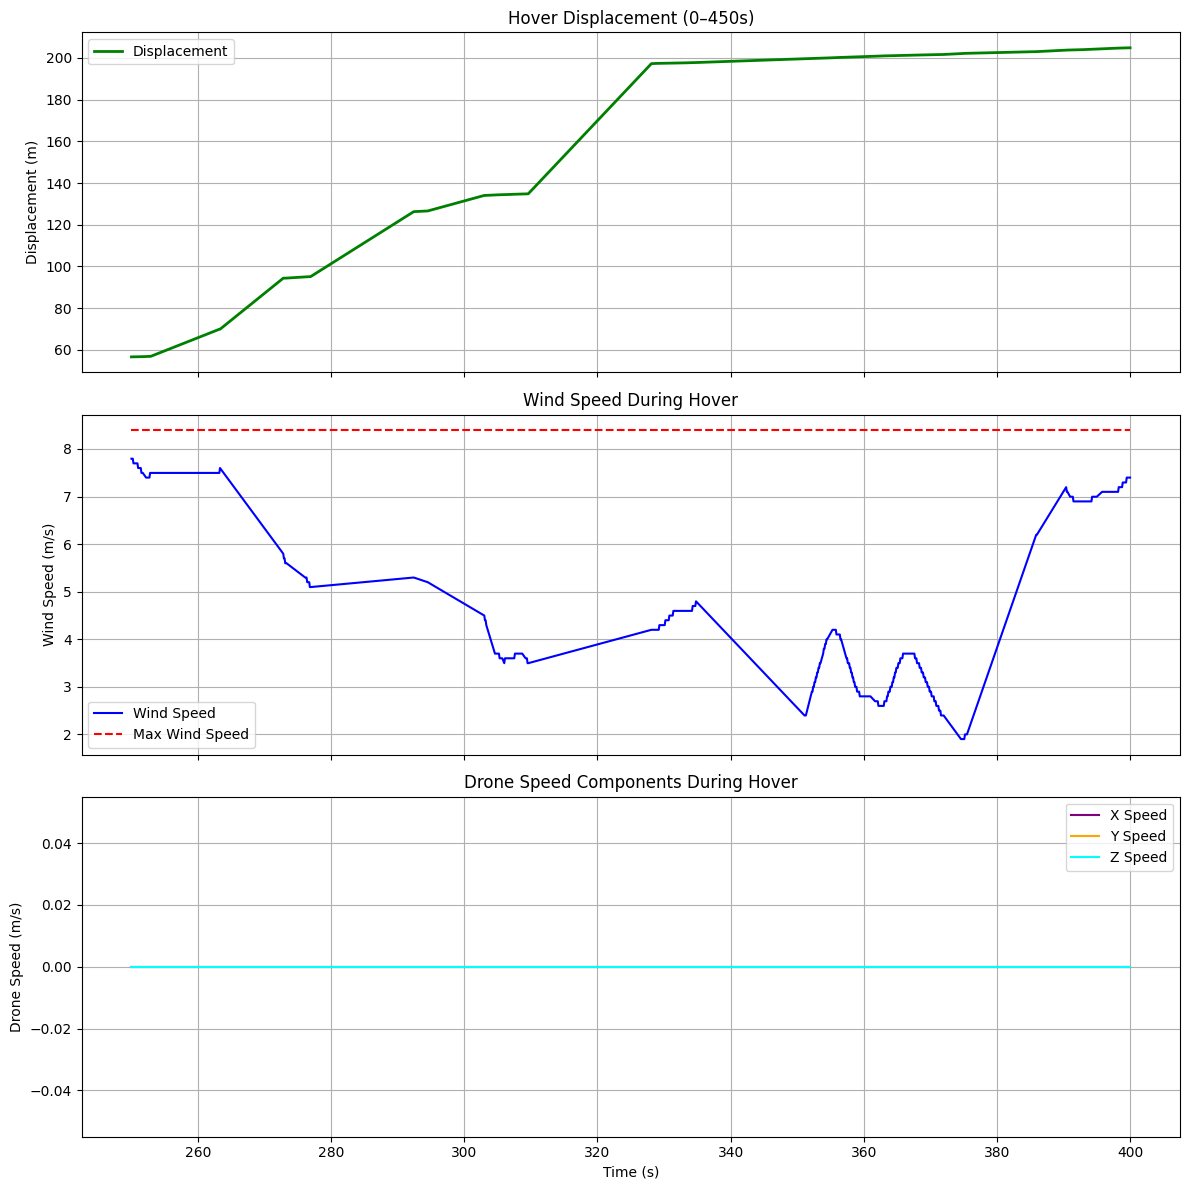

In [ ]:

hover_df = df[
    (df['OSD.hSpeed [MPH]'] < 0.1) &
    (df['OSD.zSpeed [MPH]'].abs() < 0.1)
].copy().reset_index(drop=True)


lat_diff = hover_df['OSD.latitude'].diff().abs()
lon_diff = hover_df['OSD.longitude'].diff().abs()
tiny_motion = (lat_diff < 0.00005) & (lon_diff < 0.00005)
tiny_motion.iloc[0] = True
hover_df = hover_df[tiny_motion].reset_index(drop=True)


hover_displacements = [0]
hover_times = [hover_df.loc[0, 'OSD.flyTime [s]']]
for i in range(1, len(hover_df)):
    coord1 = (hover_df.loc[i-1, 'OSD.latitude'], hover_df.loc[i-1, 'OSD.longitude'])
    coord2 = (hover_df.loc[i, 'OSD.latitude'], hover_df.loc[i, 'OSD.longitude'])
    dist = geodesic(coord1, coord2).meters
    hover_displacements.append(hover_displacements[-1] + dist)
    hover_times.append(hover_df.loc[i, 'OSD.flyTime [s]'])


disp_array = np.array(hover_displacements)
time_array = np.array(hover_times)


time_mask = (time_array >= 250) & (time_array <= 400)
disp_array = disp_array[time_mask]
time_array = time_array[time_mask]
hover_df = hover_df[
    (hover_df['OSD.flyTime [s]'] >= 250) & (hover_df['OSD.flyTime [s]'] <= 400)
].reset_index(drop=True)



fig, axs = plt.subplots(3, 1, figsize=(12, 12), sharex=True)

# 📈 Hover Displacement
axs[0].plot(time_array, disp_array, 'g-', label='Displacement', linewidth=2)
axs[0].set_ylabel('Displacement (m)')
axs[0].set_title('Hover Displacement (0–450s)')
axs[0].grid(True)
axs[0].legend()

# 🌬️ Wind Speed
axs[1].plot(hover_df['OSD.flyTime [s]'], hover_df['windSpeed_mps'], label='Wind Speed', color='b')
axs[1].plot(hover_df['OSD.flyTime [s]'], hover_df['maxWindSpeed_mps'], label='Max Wind Speed', linestyle='--', color='r')
axs[1].set_ylabel('Wind Speed (m/s)')
axs[1].set_title('Wind Speed During Hover')
axs[1].grid(True)
axs[1].legend()

# 🚁 Drone Speed Components
axs[2].plot(hover_df['OSD.flyTime [s]'], hover_df['xSpeed_mps'], label='X Speed', color='purple')
axs[2].plot(hover_df['OSD.flyTime [s]'], hover_df['ySpeed_mps'], label='Y Speed', color='orange')
axs[2].plot(hover_df['OSD.flyTime [s]'], hover_df['zSpeed_mps'], label='Z Speed', color='cyan')
axs[2].set_xlabel('Time (s)')
axs[2].set_ylabel('Drone Speed (m/s)')
axs[2].set_title('Drone Speed Components During Hover')
axs[2].grid(True)
axs[2].legend()

plt.tight_layout()
plt.show()

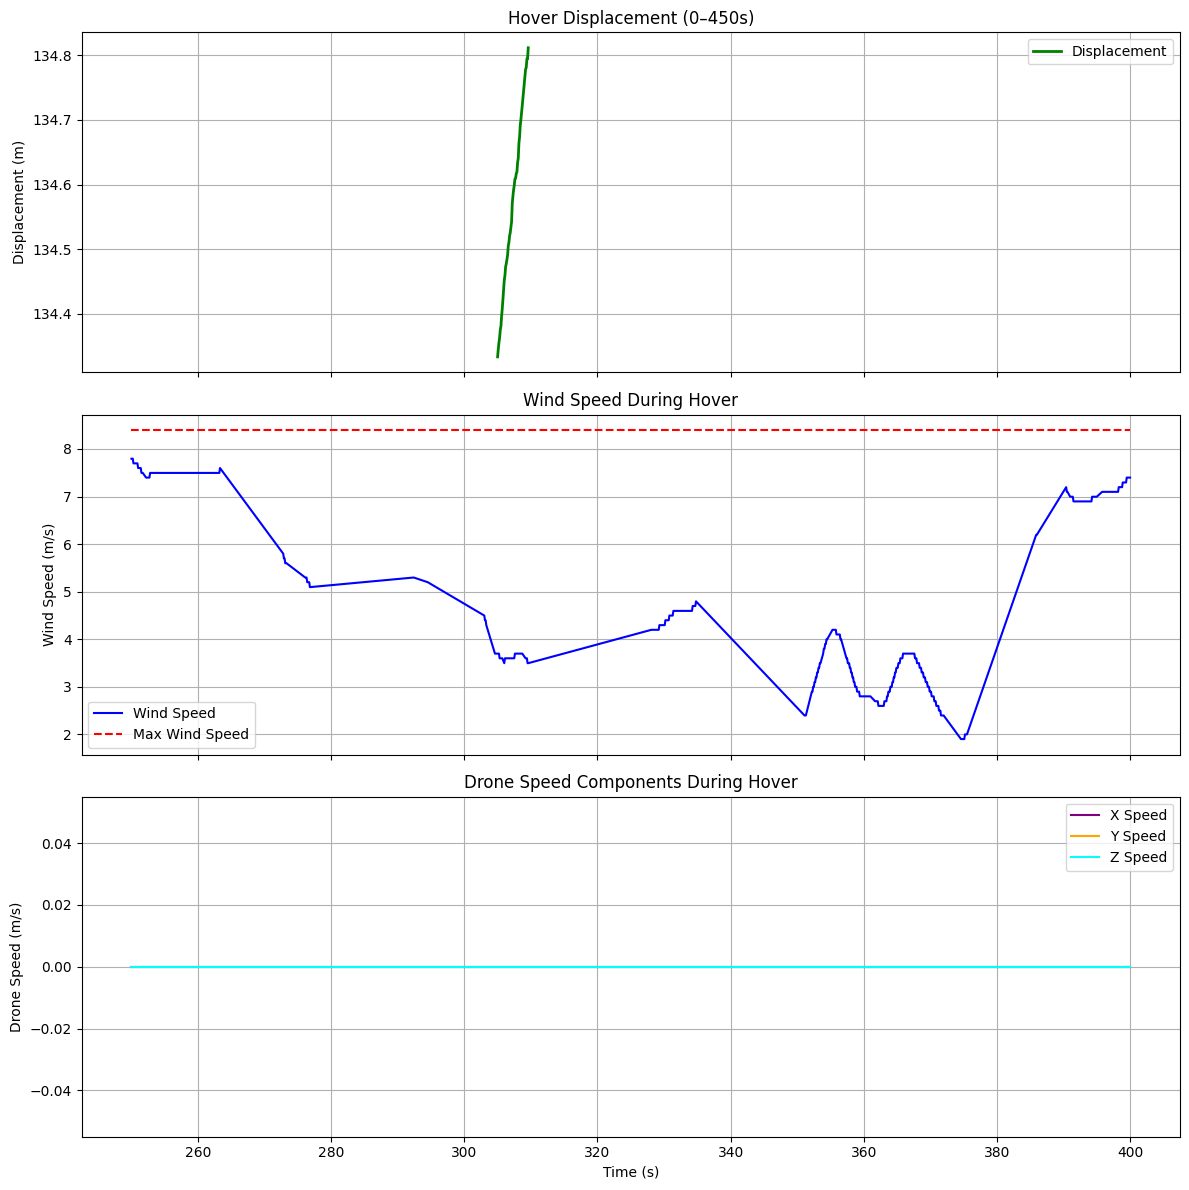

In [ ]:

hover_df = df[
    (df['OSD.hSpeed [MPH]'] < 0.1) &
    (df['OSD.zSpeed [MPH]'].abs() < 0.1)
].copy().reset_index(drop=True)

lat_diff = hover_df['OSD.latitude'].diff().abs()
lon_diff = hover_df['OSD.longitude'].diff().abs()
tiny_motion = (lat_diff < 0.00005) & (lon_diff < 0.00005)
tiny_motion.iloc[0] = True
hover_df = hover_df[tiny_motion].reset_index(drop=True)


hover_displacements = [0]
hover_times = [hover_df.loc[0, 'OSD.flyTime [s]']]
for i in range(1, len(hover_df)):
    coord1 = (hover_df.loc[i-1, 'OSD.latitude'], hover_df.loc[i-1, 'OSD.longitude'])
    coord2 = (hover_df.loc[i, 'OSD.latitude'], hover_df.loc[i, 'OSD.longitude'])
    dist = geodesic(coord1, coord2).meters
    hover_displacements.append(hover_displacements[-1] + dist)
    hover_times.append(hover_df.loc[i, 'OSD.flyTime [s]'])

disp_array = np.array(hover_displacements)
time_array = np.array(hover_times)


time_mask = (time_array >= 305) & (time_array <= 310)
disp_array = disp_array[time_mask]
time_array = time_array[time_mask]
hover_df = hover_df[
    (hover_df['OSD.flyTime [s]'] >= 250) & (hover_df['OSD.flyTime [s]'] <= 400)
].reset_index(drop=True)

fig, axs = plt.subplots(3, 1, figsize=(12, 12), sharex=True)

# 📈 Hover Displacement
axs[0].plot(time_array, disp_array, 'g-', label='Displacement', linewidth=2)
axs[0].set_ylabel('Displacement (m)')
axs[0].set_title('Hover Displacement (0–450s)')
axs[0].grid(True)
axs[0].legend()

# 🌬️ Wind Speed
axs[1].plot(hover_df['OSD.flyTime [s]'], hover_df['windSpeed_mps'], label='Wind Speed', color='b')
axs[1].plot(hover_df['OSD.flyTime [s]'], hover_df['maxWindSpeed_mps'], label='Max Wind Speed', linestyle='--', color='r')
axs[1].set_ylabel('Wind Speed (m/s)')
axs[1].set_title('Wind Speed During Hover')
axs[1].grid(True)
axs[1].legend()

# 🚁 Drone Speed Components
axs[2].plot(hover_df['OSD.flyTime [s]'], hover_df['xSpeed_mps'], label='X Speed', color='purple')
axs[2].plot(hover_df['OSD.flyTime [s]'], hover_df['ySpeed_mps'], label='Y Speed', color='orange')
axs[2].plot(hover_df['OSD.flyTime [s]'], hover_df['zSpeed_mps'], label='Z Speed', color='cyan')
axs[2].set_xlabel('Time (s)')
axs[2].set_ylabel('Drone Speed (m/s)')
axs[2].set_title('Drone Speed Components During Hover')
axs[2].grid(True)
axs[2].legend()

plt.tight_layout()
plt.show()